1. Look at the dataset
    - Different sizes of images
    - Samples with wrong labels
    - Different backgrounds
    - File formats
    - Intensity range
    - Class distribution
2. Pre-process the data
    - Padded the images so they are square
    - Resized the images to a managable size
3. Experimental setup
    -   Single train/val/test split: 70%/ 15%/ 15%
    -   Set data augmentation
    -   Create data loaders
4. Transfer learning
    - SOTA models on imagenet
    - Add and train new top/predictor
    - Fine-tune all or some feature learning layers 
5. Loss and metrics
    -   Loss: categorical cross-entropy
    -   Metrics: Accuracy, sensitivity, specificity, confusion matrix, training and inference time?
6. Set your callbacks and track your experiments
    - Early stopping - patience
    - Model check point
    - Learning rate scheduler
    - Weights and biases (train/val loss)
7. Set your main hyperparameters
    - batch size
    - learning rate
    - number of epochs
8. Train 
    - Train your model
    - Need to write your training code in pure Python and PyTorch or use another library like lightning or ignite
9. Test 
    - Run prediction on your test set
    - Extract relevant metrics
    - Measure inference time

- Other suggestions:
    - Use config files to make experimenting different configs easily
    - Design locally, but run experiments in the cluster



testing asd3


## Why use transfer learning?

There are a few main benefits to using transfer learning:

1. Can leverage an existing **pre-trained model** which has been proven to work on problems similar to our own - transfer learinnig offers a better starting point.
2. Can leverage a working model which has **already learned** patterns on similar data to our own. This often results in achieving **great results with less custom data**.
3. With better starting point and learning rate, transfer learning enables a more accurate output by providing a machine learning model to converge at a higher performance level.
4. Since we are leveraging a pre-trainiend model, the learning can achieve faster training than traditional methods (however performance may not be much higher than traditional methods).  [Source: Kaggle.com](https://www.kaggle.com/general/291011)



*We'll be putting these to the test for our Chemotherapy Extravasation problem, we'll take a computer vision model pretrained on ImageNet and try to leverage its underlying learned representations for classifying images of normal, mild, moderate, and severe extravasation injuries.*

Some of the main applications of Transfer learning include:
* Natural Language Processing (NLP)
* Computer Vision (CV)
* Neural Networks
* Gaming Industry


### The Future of Transfer Learning
Although many of the big *breakthroughs* in AI have been the result of using "Big-Data", there are situations where large datasets are not available - an example could be a remote village where medical issues are recorded at a hgih level but images and labels for the issue are not readily available (or practical to capture/store).

The limited datasets, or "small-data" can still be used using transfer learning by selecting a model that has been pre-trained on a larger, similar dataset, and then retraining the model slightly with the smaller dataset to address the specific problem.

### The Extravasation dataset contains a total of 84 images, pre-classified into normal, mild, moderate, and severe classes.



## Mount drive for Google CoLab

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Lets now import all the necessary modules....

In [ ]:
import torch
import glob
import matplotlib.pylab as plt
from torch.utils.data import Dataset
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms, models
from sklearn.model_selection import StratifiedShuffleSplit
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR


## Now let's setup device agnostic code.

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, you can turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`.

In [ ]:
# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## Define the dataset



In [ ]:
class TorchVisionDataset(Dataset):
    def __init__(self,data_dic, transform = None):
        self.file_paths = data_dic["X"]
        self.labels = data_dic["Y"]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    
    def __getitem__(self,idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]

        #lazily open image
        image = Image.open(file_path)

        #convert to rgb
        image = image.convert("RGB")

        if self.transform:
            image = self.transform(image)
        return image, label
        


In [ ]:
#images = glob.glob("images/*/*")
images = glob.glob("/content/drive/MyDrive/ENSF645_Assign2/*/*.*")
images = np.array(images)
labels = np.array([f.split("/")[-2] for f in images])
print(len(images))
print(labels.size)
print(images[0])
print(labels[0])

84
84
/content/drive/MyDrive/ENSF645_Assign2/3_severe/four(1).png
3_severe


In [ ]:
classes = np.unique(labels).flatten()
print(classes)
labels_int = np.zeros(labels.size, dtype = np.int64)
print(labels_int.shape)
for i,j in enumerate(classes):
    labels_int[labels == j] = i 

['0_normal' '1_mild' '2_moderate' '3_severe']
(84,)


In [ ]:
for i in range(4):
    print("Label", i, ":", (labels_int == i).sum())

Label 0 : 20
Label 1 : 16
Label 2 : 25
Label 3 : 23


## Visualize and Image

A major process in any machine learning experiment is to "know the data".  We know that we have a variety of images in teh dataset so lets have a look at one....

Random image path: /content/drive/MyDrive/ENSF645_Assign2/0_normal/normal(b).jpeg
Image class: 0_normal
Image height: 459
Image width: 612


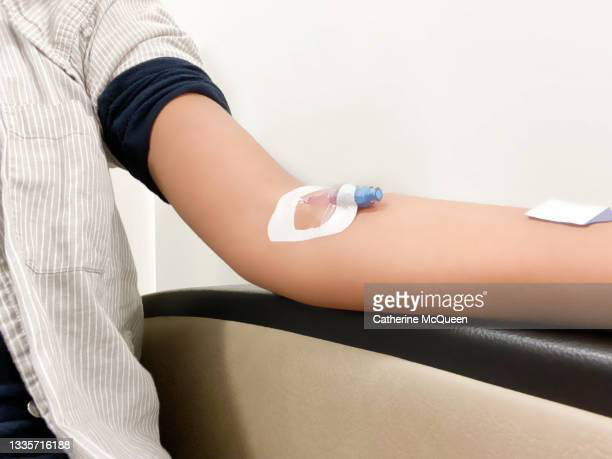

In [ ]:
import random
from PIL import Image
from pathlib import Path

# Set seed
random.seed(42) # <- try changing this and see what happens
#image_path = Path("images/")
image_path = Path("/content/drive/MyDrive/ENSF645_Assign2/")
# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*.*"))
image_path_list

#2. Get random image path
random_image_path = random.choice(image_path_list)

# # 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# # 4. Open image
img = Image.open(random_image_path)

# # 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [ ]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size= 0.25, random_state=100)
sss.get_n_splits(images,labels_int)
dev_index, test_index = next(sss.split(images,labels_int))

dev_images = images[dev_index]
dev_labels = labels_int[dev_index]

test_images = images[test_index]
test_labels = labels_int[test_index] 

In [ ]:
sss2 = StratifiedShuffleSplit(n_splits = 1, test_size= 0.25, random_state=100)
sss2.get_n_splits(dev_images,dev_labels)
train_index, val_index = next(sss2.split(dev_images,dev_labels))

train_images = images[train_index]
train_labels = labels_int[train_index]

val_images = images[val_index]
val_labels = labels_int[val_index] 

In [ ]:
print("Train set:", train_images.size)
print("Val set:", val_images.size)
print("Test set:", test_images.size)


Train set: 47
Val set: 16
Test set: 21


In [ ]:
train_set = {"X": train_images, "Y": train_labels}
val_set = {"X": val_images, "Y": val_labels}
test_set = {"X": test_images, "Y": test_labels}

## Exploring Transforms for data augmentation

Method to plot images

In [ ]:
def plot_images(imgs, orig_img=None, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    with_orig=True if orig_img is not None else False

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False, figsize=(12, 12))
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set_ylabel(row_title[row_idx], rotation=0, labelpad=65)

    

### Exploring AutoAugment

Plotting auto augment policies to see the affect on a sample image

In [ ]:
policies = [transforms.AutoAugmentPolicy.CIFAR10, transforms.AutoAugmentPolicy.IMAGENET, transforms.AutoAugmentPolicy.SVHN]
augmenters = [transforms.AutoAugment(policy) for policy in policies]
orig_img=Image.open("images/0_normal/normal 8.png").convert("RGB")

imgs = [
    [augmenter(orig_img) for _ in range(4)]
    for augmenter in augmenters
]
row_title = [str(policy).split('.')[-1] for policy in policies]
plot_images(imgs, orig_img=orig_img, row_title=row_title)

These policies seem to augment the image too much at times for the purposes of our classification, as color is an important feature.

### Exploring random transforms

Random transforms can change the image in various ways to hopefully help the model generalize better. In our case, since the data size is very limited, we will use transforms to prevent the model from overfitting as much as possible. More transforms can be found here https://pytorch.org/vision/main/auto_examples/plot_transforms.html

Plotting examples of random transforms on a sample image

In [ ]:
augmenters = [transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
              transforms.RandomPerspective(distortion_scale=0.4), transforms.RandomRotation(degrees=(0,180)), transforms.RandomAutocontrast(), transforms.RandomInvert(),
              transforms.RandomAdjustSharpness(sharpness_factor=2)]

imgs = [
    [augmenter(orig_img) for _ in range(5)]
    for augmenter in augmenters
]
row_title = [transform._get_name() for transform in augmenters]
plot_images(imgs, orig_img=orig_img, row_title=row_title)

From the above transforms, we will use all except for RandomInvert and RandomAutocontrast as they change the color too much, which is an important feature for our classification.

# Defining the experimental data

### Selecting Model

Selecting the pretrained model and weights. For our experiment, we will be using ResNet-18, which is a convolutional neural network which is 18 layers deep, and is trained on over a million images from the ImageNet database. There are larger models available with more parameters, but since our data size is very limited, we have chosen a relatively smaller model.

In [ ]:
selected_model=resnet18
pretrained_weights=ResNet18_Weights.IMAGENET1K_V1

### Defining the transforms

For training, we will first augment the data with random transformation followed by the same standard transforms used in the training of ResNet18. For testing, only the ResNet18 transforms will be applied.

In [ ]:
torchvision_transform = torch.nn.Sequential(transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), transforms.ColorJitter(brightness=0.2,saturation=0.2, contrast=0.2),
              transforms.RandomPerspective(distortion_scale=0.4), transforms.RandomRotation(degrees=(0,180)), transforms.RandomAdjustSharpness(sharpness_factor=2),
              pretrained_weights.transforms())


torchvision_transform_test = pretrained_weights.transforms()

Define training, validation and testings Datasets and Dataloaders

In [ ]:
train_dataset = TorchVisionDataset(train_set, transform=torchvision_transform)
val_dataset = TorchVisionDataset(val_set, transform=torchvision_transform)
test_dataset = TorchVisionDataset(test_set, transform=torchvision_transform_test)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size= 32, shuffle = True, num_workers= 0)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size= 32, num_workers= 0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size= 32, num_workers= 0)

## Dataset statistics

In [ ]:
def get_dataset_stats(data_loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in data_loader:
        data = data[0]  # Get the images to compute the stgatistics
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

print(get_dataset_stats(trainloader))

(tensor([0.4637, 0.2049, 0.2907]), tensor([0.9032, 0.8164, 0.8299]))


In [ ]:
train_iterator = iter(trainloader)
train_batch = next(train_iterator)

In [ ]:
print(train_batch[0].size())
print(train_batch[1].size())

torch.Size([32, 3, 224, 224])
torch.Size([32])


## Lets visualize some of the transformed images

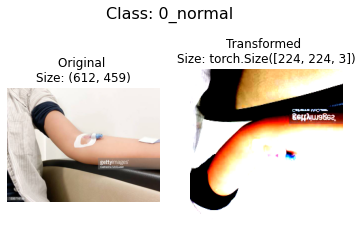

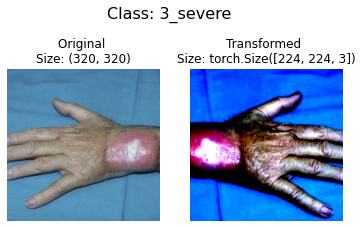

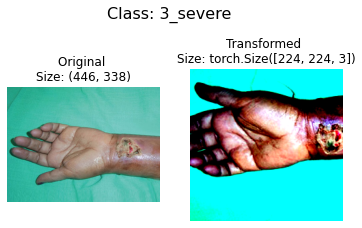

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=torchvision_transform, 
                        n=3)

# Defining Model
Defining model extension of nn.Module which will load the selected model's feature extractor and add a linear classifier layer on top.  
This class will load the selected model's pretrained weights if transfer is true. The model will also fix the feature extractor layer and not train the parameters if fixed_feature_extractor is true.

In [ ]:
class Model(nn.Module):
    def __init__(self,  num_classes, input_shape, transfer=False, fixed_feature_extractor=False):
        super().__init__()

        self.transfer = transfer
        self.num_classes = num_classes
        self.input_shape = input_shape
        
        # loading pretrained_weights if transfer is True
        self.feature_extractor =  selected_model(weights=(pretrained_weights if transfer else None))

        if fixed_feature_extractor:
            # layers are frozen by using eval()
            self.feature_extractor.eval()
            # freeze params
            for param in self.feature_extractor.parameters():
                param.requires_grad = False

        n_features = self._get_conv_output(self.input_shape)
        self.classifier = nn.Linear(n_features, num_classes)

    def _get_conv_output(self, shape):
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self.feature_extractor(tmp_input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    # will be used during inference
    def forward(self, x):
       x = self.feature_extractor(x)
       x = x.view(x.size(0), -1)
       x = self.classifier(x)
       
       return x


Creating a model which will load the pretrained weights and fix the feature extractor parameters, only training the classifier.

In [ ]:
net = Model(4, (3,224,224), transfer=True, fixed_feature_extractor=True)
net.to(device)

Model(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

Defining the criterion, optimizer, and scheduler

In [ ]:
# CrossEntropyLoss for classification
criterion = nn.CrossEntropyLoss()

# selecting optimizer
optimizer = torch.optim.AdamW(net.parameters(), lr = 0.001)

# exponential schedule will multiply the learning rate by gamma after each epoch
scheduler = ExponentialLR(optimizer, gamma=0.9)

Training

In [ ]:
nepochs = 30
PATH = 'EV_net.pth' # Path to save the best model

best_loss = 1e+20
for epoch in range(nepochs):  # loop over the dataset multiple times
    # Training Loop
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'{epoch + 1},  train loss: {train_loss / (i+1):.3f},', end = ' ')
    scheduler.step()
    
    val_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
        print(f'val loss: {val_loss / (i+1):.3f}')
        
        # Save best model
        if val_loss < best_loss:
            print("Saving model")
            torch.save(net.state_dict(), PATH)
            best_loss = val_loss
        
print('Finished Training')

1,  train loss: 1.621, val loss: 1.328
Saving model
2,  train loss: 1.015, val loss: 1.285
Saving model
3,  train loss: 0.774, val loss: 1.180
Saving model
4,  train loss: 0.711, val loss: 1.054
Saving model
5,  train loss: 0.592, val loss: 1.116
6,  train loss: 0.611, val loss: 1.026
Saving model
7,  train loss: 0.550, val loss: 1.017
Saving model
8,  train loss: 0.482, val loss: 1.117
9,  train loss: 0.409, val loss: 0.946
Saving model
10,  train loss: 0.415, val loss: 1.133
11,  train loss: 0.418, val loss: 1.201
12,  train loss: 0.364, val loss: 1.297
13,  train loss: 0.356, val loss: 1.171
14,  train loss: 0.388, val loss: 1.211
15,  train loss: 0.305, val loss: 1.145
16,  train loss: 0.355, val loss: 1.140
17,  train loss: 0.333, val loss: 1.227
18,  train loss: 0.335, val loss: 1.163
19,  train loss: 0.294, val loss: 1.259
20,  train loss: 0.279, val loss: 1.235
21,  train loss: 0.322, val loss: 1.130
22,  train loss: 0.319, val loss: 1.255
23,  train loss: 0.298, val loss: 1.25

Load the best model found to be used for testing

In [ ]:

net = Model(4, (3,224,224), False)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Evaluate the model on the testing data

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Accuracy of the network on the test images: 42.857142857142854 %


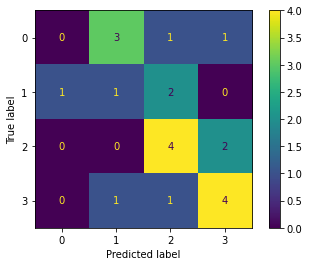

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(labels, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               )
disp.plot()

plt.show()